## Simple benchmark using LGB & holdout

Benchamrk with LGB

In [1]:
import os
import sys
from datetime import datetime

In [2]:
sys.path.insert(0, os.path.abspath('/opt/vssexclude/personal/kaggle/kaggle_tab_jul'))

In [3]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [4]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit

import src.common as common
import src.munging as process_data
import src.config.constants as constants
import src.cv as cv
import src.modeling as model

In [5]:
logger = common.get_logger('sub_1')
RUN_ID = datetime.now().strftime("%m%d_%H%M")
MODEL_NAME = "lgb_benhmark"
SEED = 42

train_df, test_df, sample_submission_df = process_data.read_processed_data(logger, 
                                                                           constants.PROCESSED_DATA_DIR, 
                                                                           train=True, 
                                                                           test=True, 
                                                                           sample_submission=True)

[INFO]2021-07-20 20:16:00,609:sub_1:Reading Data from /opt/vssexclude/personal/kaggle/kaggle_tab_jul/data/processed...
[INFO]2021-07-20 20:16:00,658:sub_1:Shape of train_df : (7111, 12)
[INFO]2021-07-20 20:16:00,662:sub_1:Shape of test_df : (2247, 9)
[INFO]2021-07-20 20:16:00,666:sub_1:Shape of sample_submission_df : (2247, 4)


In [6]:
train_df.shape, test_df.shape, sample_submission_df.shape

((7111, 12), (2247, 9), (2247, 4))

In [7]:
features = pd.read_parquet(f"{constants.FEATURES_DATA_DIR}/features.parquet")

targets = ["target_carbon_monoxide", "target_benzene", "target_nitrogen_oxides"]
date = ["date_time"]

test_df_org = test_df.copy()
targets_df = train_df[targets]

combinded_df = pd.concat([train_df.drop(targets, axis=1), test_df])
combinded_df = combinded_df.reset_index(drop=True)

date_features = [
    "month",
    "quarter",
    "weekofyear",
    "hour",
    "day",
    "dayofweek",
    "day_type",
    "dayofyear",
    "is_month_start",
    "is_month_end",
    "is_quarter_start",
    "is_quarter_end",
    "us_season",
    "part_of_day",
]

combinded_df = pd.concat([combinded_df, features[date_features]], axis=1)

for name in combinded_df.select_dtypes("bool"):
    combinded_df[name] = combinded_df[name].astype(int)

for name in combinded_df.select_dtypes(include=["object", "category"]):
    lb = LabelEncoder()
    combinded_df[name] = lb.fit_transform(combinded_df[name])

train_df = combinded_df.iloc[0: len(train_df)]
test_df = combinded_df.iloc[len(train_df):]

train_df = pd.concat([train_df, targets_df], axis=1)

In [8]:
train_df.shape, test_df.shape, sample_submission_df.shape

((7111, 26), (2247, 23), (2247, 4))

In [9]:
# Training on first six months
train_months = [3, 4, 5, 6, 7, 8]
# Holdout on last three months
validation_months = [10, 11, 12]

training_df, validation_df = cv.get_data_splits_by_month(logger=logger, df=train_df, train_months=train_months, validation_months=validation_months)

[INFO]2021-07-20 20:16:01,024:sub_1:Splitting the data into train and holdout based on months...
[INFO]2021-07-20 20:16:01,025:sub_1:Training months [3, 4, 5, 6, 7, 8]
[INFO]2021-07-20 20:16:01,026:sub_1:Validation months [10, 11, 12]
[INFO]2021-07-20 20:16:01,030:sub_1:Shape of the training data (4182, 26) 
[INFO]2021-07-20 20:16:01,031:sub_1:Shape of the validation data (2208, 26)


In [10]:
predictors = ['month',
       'quarter', 'weekofyear', 'hour', 'day', 'dayofweek', 'day_type',
       'dayofyear', 'is_month_start', 'is_month_end', 'is_quarter_start',
       'is_quarter_end', 'us_season', 'part_of_day', 'deg_C', 'relative_humidity', 'absolute_humidity',
       'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', ]

lgb_params = {
                'objective' : 'regression',
                'boosting_type' : 'gbdt',
                'learning_rate' : 0.1,
                'num_leaves' : 31,
                'tree_learner' : 'serial',
                'n_jobs' :-1,
                'seed' : SEED,
                'max_depth' : -1,
                'max_bin' : 255,
                'metric' : 'rmse',
                'verbose' : -1
                }

In [11]:
results_dict_co = model.lgb_train_validate_on_holdout(
    logger=logger,
    run_id=RUN_ID,
    training=training_df,
    validation=validation_df,
    test_X=test_df,
    predictors=predictors,
    target="target_carbon_monoxide",
    params=lgb_params,
    n_estimators=10000,
    early_stopping_rounds=100,
    cat_features='auto',
    verbose_eval=100,
    label_name="co",
)

[INFO]2021-07-20 20:16:02,193:sub_1:Training using LGB and validating on holdout
[INFO]2021-07-20 20:16:02,196:sub_1:Shape of train_X, train_Y, validation_X, validation_Y: (4182, 22), (4182,), (2208, 22), (2208,)
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.172873	valid_1's rmse: 0.809736
[200]	training's rmse: 0.126656	valid_1's rmse: 0.808714
Early stopping, best iteration is:
[127]	training's rmse: 0.156768	valid_1's rmse: 0.807289
[INFO]2021-07-20 20:16:02,496:sub_1:Validation Score 0.19059926319060425
[INFO]2021-07-20 20:16:02,497:sub_1:Best Iteration 127
[INFO]2021-07-20 20:16:02,554:sub_1:Retraining on the entire data including validation
[INFO]2021-07-20 20:16:02,557:sub_1:Shape of train_X, train_Y: (6390, 22), (6390,)
[INFO]2021-07-20 20:16:02,697:sub_1:Predicting on test data: (2247, 23)
[INFO]2021-07-20 20:16:02,722:sub_1:Training/Prediction completed!


In [12]:
results_dict_benzene = model.lgb_train_validate_on_holdout(
    logger=logger,
    run_id=RUN_ID,
    training=training_df,
    validation=validation_df,
    test_X=test_df,
    predictors=predictors,
    target="target_benzene",
    params=lgb_params,
    n_estimators=10000,
    early_stopping_rounds=100,
    cat_features='auto',
    verbose_eval=100,
    label_name="co",
)

[INFO]2021-07-20 20:16:05,795:sub_1:Training using LGB and validating on holdout
[INFO]2021-07-20 20:16:05,799:sub_1:Shape of train_X, train_Y, validation_X, validation_Y: (4182, 22), (4182,), (2208, 22), (2208,)
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.585734	valid_1's rmse: 1.84096
[200]	training's rmse: 0.423861	valid_1's rmse: 1.8463
Early stopping, best iteration is:
[177]	training's rmse: 0.453858	valid_1's rmse: 1.83964
[INFO]2021-07-20 20:16:06,164:sub_1:Validation Score 0.11384535686993831
[INFO]2021-07-20 20:16:06,165:sub_1:Best Iteration 177
[INFO]2021-07-20 20:16:06,215:sub_1:Retraining on the entire data including validation
[INFO]2021-07-20 20:16:06,220:sub_1:Shape of train_X, train_Y: (6390, 22), (6390,)
[INFO]2021-07-20 20:16:06,439:sub_1:Predicting on test data: (2247, 23)
[INFO]2021-07-20 20:16:06,478:sub_1:Training/Prediction completed!


In [13]:
results_dict_no = model.lgb_train_validate_on_holdout(
    logger=logger,
    run_id=RUN_ID,
    training=training_df,
    validation=validation_df,
    test_X=test_df,
    predictors=predictors,
    target="target_nitrogen_oxides",
    params=lgb_params,
    n_estimators=10000,
    early_stopping_rounds=100,
    cat_features='auto',
    verbose_eval=100,
    label_name="co",
)

[INFO]2021-07-20 20:16:06,493:sub_1:Training using LGB and validating on holdout
[INFO]2021-07-20 20:16:06,498:sub_1:Shape of train_X, train_Y, validation_X, validation_Y: (4182, 22), (4182,), (2208, 22), (2208,)
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 13.6871	valid_1's rmse: 276.612
[200]	training's rmse: 9.95793	valid_1's rmse: 274.358
[300]	training's rmse: 7.7854	valid_1's rmse: 273.996
[400]	training's rmse: 6.28664	valid_1's rmse: 272.966
[500]	training's rmse: 5.10416	valid_1's rmse: 272.677
[600]	training's rmse: 4.20016	valid_1's rmse: 272.248
[700]	training's rmse: 3.52066	valid_1's rmse: 271.976
[800]	training's rmse: 2.95672	valid_1's rmse: 271.61
[900]	training's rmse: 2.51699	valid_1's rmse: 271.291
[1000]	training's rmse: 2.12304	valid_1's rmse: 270.986
[1100]	training's rmse: 1.77195	valid_1's rmse: 270.948
[1200]	training's rmse: 1.51243	valid_1's rmse: 270.906
[1300]	training's rmse: 1.29353	valid_1's rmse: 270.773
[1400]	t

[INFO]2021-07-20 20:16:14,327:sub_1:Saving /opt/vssexclude/personal/kaggle/kaggle_tab_jul/oof/y_val_no_lgb_benhmark_0720_2016_0.89021.csv
[INFO]2021-07-20 20:16:14,336:sub_1:Saving /opt/vssexclude/personal/kaggle/kaggle_tab_jul/fi/fi_no_lgb_benhmark_0720_2016_0.89021.csv


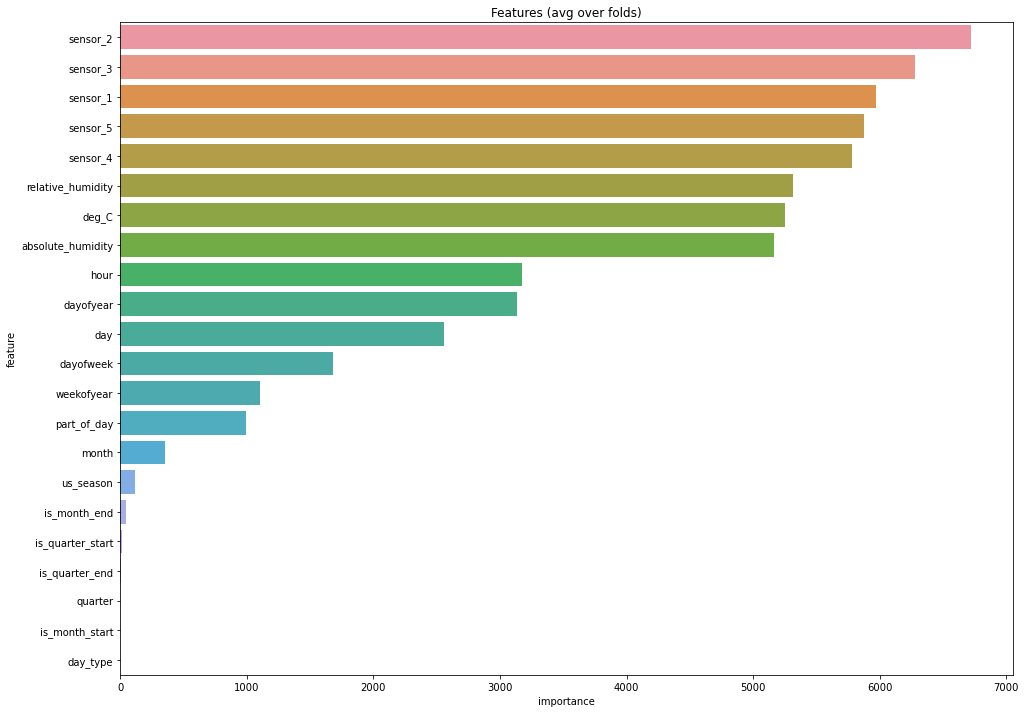

In [14]:
common.save_artifacts_holdout(
    logger=logger,
    is_test=False,
    is_plot_fi=True,
    result_dict=results_dict_no,
    model_number=MODEL_NAME,
    run_id=RUN_ID,
    oof_dir=constants.OOF_DIR,
    fi_dir=constants.FI_DIR,
    fi_fig_dir=constants.FI_FIG_DIR,
    label_name="no",
)

[INFO]2021-07-20 20:18:13,946:sub_1:Saving /opt/vssexclude/personal/kaggle/kaggle_tab_jul/oof/y_val_co_lgb_benhmark_0720_2016_0.19060.csv
[INFO]2021-07-20 20:18:13,952:sub_1:Saving /opt/vssexclude/personal/kaggle/kaggle_tab_jul/fi/fi_co_lgb_benhmark_0720_2016_0.19060.csv
[INFO]2021-07-20 20:18:14,144:sub_1:Saving /opt/vssexclude/personal/kaggle/kaggle_tab_jul/oof/y_val_benzene_lgb_benhmark_0720_2016_0.11385.csv
[INFO]2021-07-20 20:18:14,149:sub_1:Saving /opt/vssexclude/personal/kaggle/kaggle_tab_jul/fi/fi_benzene_lgb_benhmark_0720_2016_0.11385.csv


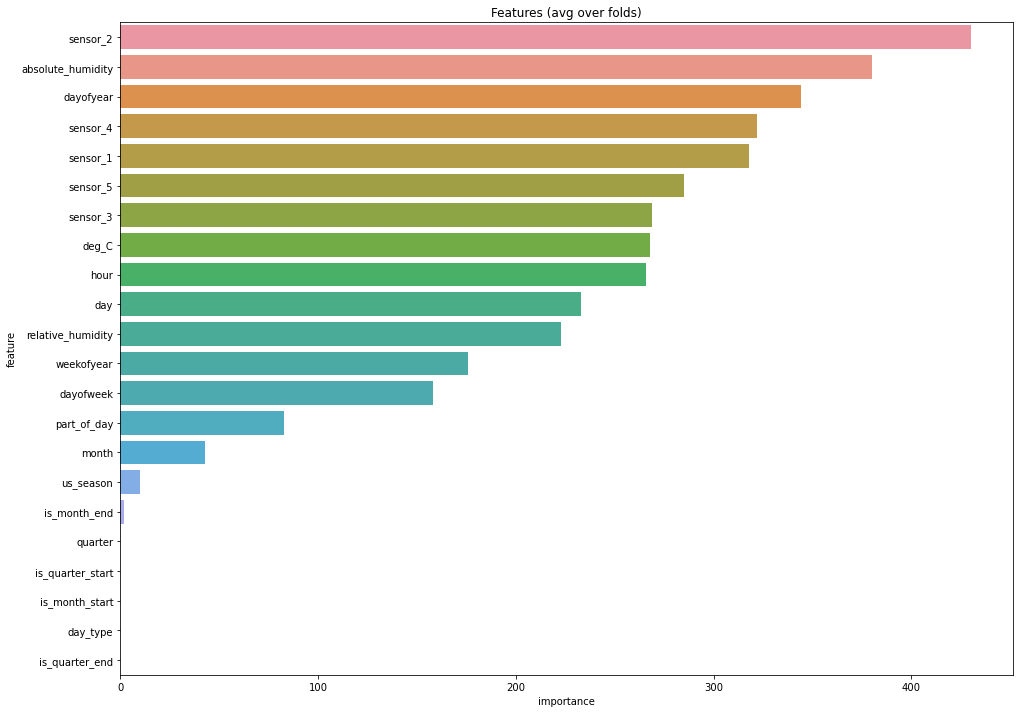

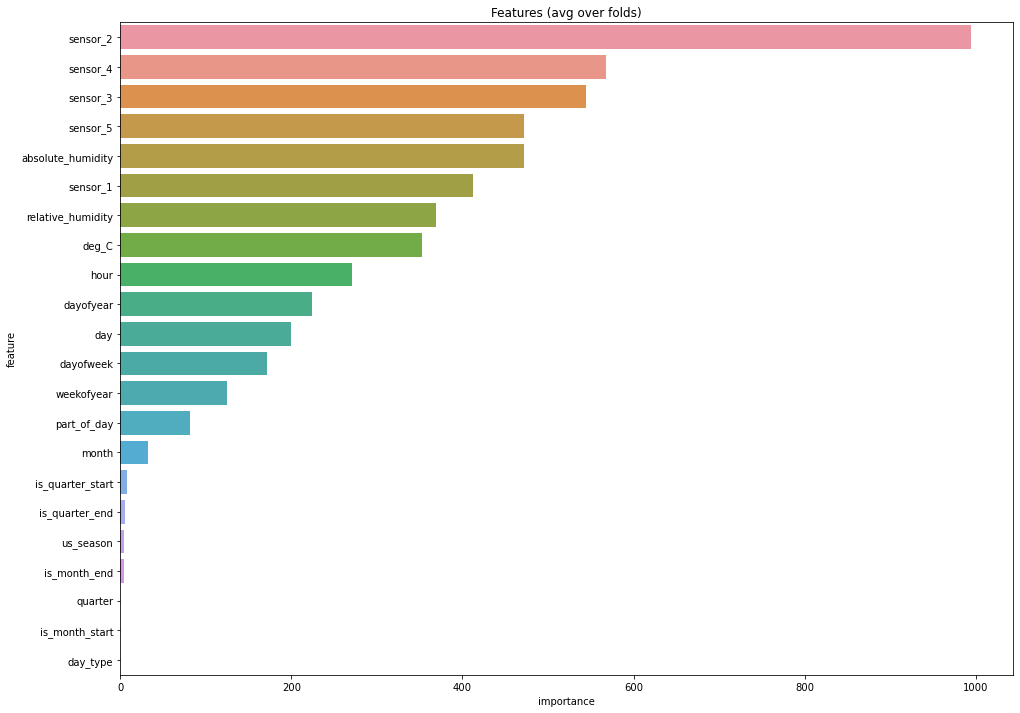

In [15]:
common.save_artifacts_holdout(
    logger=logger,
    is_test=False,
    is_plot_fi=True,
    result_dict=results_dict_co,
    model_number=MODEL_NAME,
    run_id=RUN_ID,
    oof_dir=constants.OOF_DIR,
    fi_dir=constants.FI_DIR,
    fi_fig_dir=constants.FI_FIG_DIR,
    label_name="co",
)

common.save_artifacts_holdout(
    logger=logger,
    is_test=False,
    is_plot_fi=True,
    result_dict=results_dict_benzene,
    model_number=MODEL_NAME,
    run_id=RUN_ID,
    oof_dir=constants.OOF_DIR,
    fi_dir=constants.FI_DIR,
    fi_fig_dir=constants.FI_FIG_DIR,
    label_name="benzene",
)

In [16]:
results_dict_co.keys()

dict_keys(['y_validation', 'valid_score', 'prediction', 'feature_importance'])

In [18]:
agg_val_score = common.calculate_final_score(
    RUN_ID, 
    results_dict_co,
    results_dict_benzene,
    results_dict_no)

In [25]:
print(f"agg_val_score: {agg_val_score}")
common.create_submission_file(    
    logger=logger,
    run_id=RUN_ID,
    model_number=MODEL_NAME,
    sub_dir=constants.SUBMISSION_DIR,
    score=agg_val_score,
    sub_df=sample_submission_df,
    test_df=test_df_org,
    results_dict_co=results_dict_co,
    results_dict_ben=results_dict_benzene,
    results_dict_no=results_dict_no,)

agg_val_score: 0.39821999999999996
[INFO]2021-07-20 20:26:28,299:sub_1:Saving /opt/vssexclude/personal/kaggle/kaggle_tab_jul/submissions/sub_lgb_benhmark_0720_2016_0.39822.csv


[INFO]2021-07-20 12:41:11,460:sub_1:fold 1 of 5
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 2.5	valid_1's rmse: 3.14488
Early stopping, best iteration is:
[1]	training's rmse: 2.5	valid_1's rmse: 3.14488
[INFO]2021-07-20 12:41:12,845:sub_1:Best number of iterations for fold 1 is: 1
[INFO]2021-07-20 12:41:12,846:sub_1:CV OOF Score for fold 1 is 0.44566163848260404
[INFO]2021-07-20 12:41:12,905:sub_1:fold 2 of 5
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.171058	valid_1's rmse: 0.399488
Early stopping, best iteration is:
[76]	training's rmse: 0.189791	valid_1's rmse: 0.396887
[INFO]2021-07-20 12:41:13,633:sub_1:Best number of iterations for fold 2 is: 76
[INFO]2021-07-20 12:41:13,634:sub_1:CV OOF Score for fold 2 is 0.1437274105986489
[INFO]2021-07-20 12:41:13,697:sub_1:fold 3 of 5
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.20758	valid_1's rmse: 0.331476
Early s

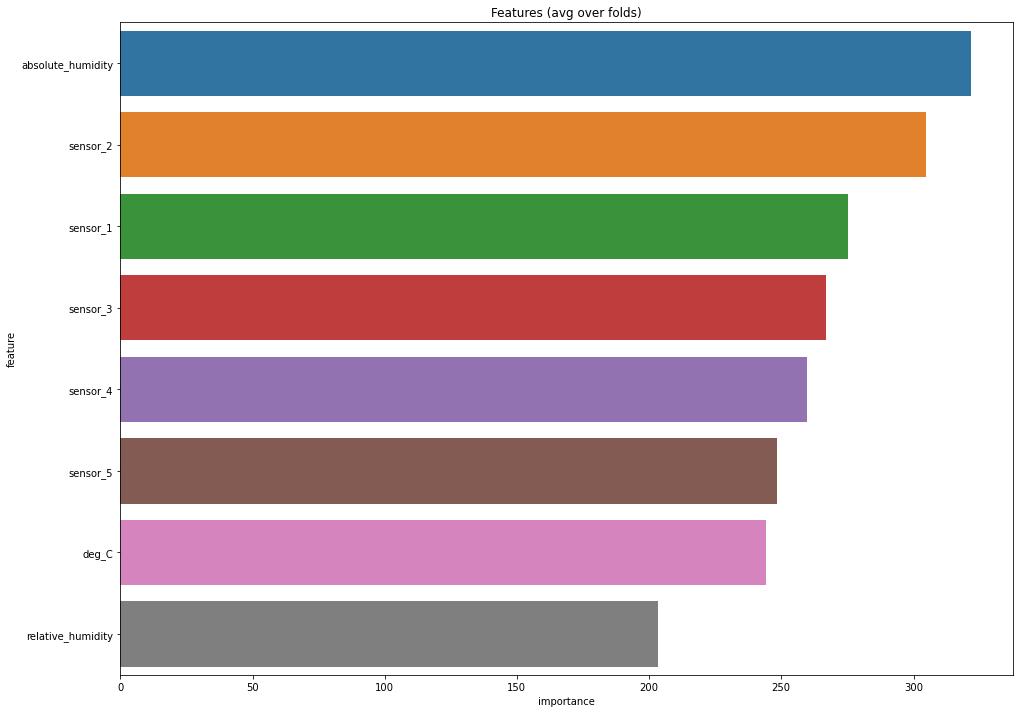

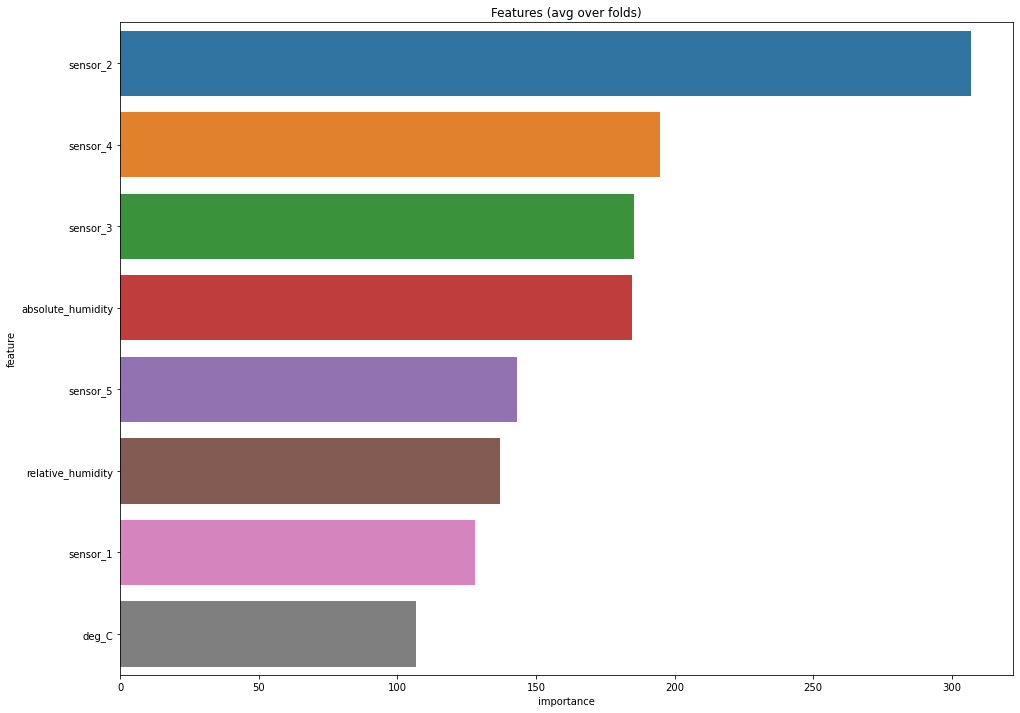

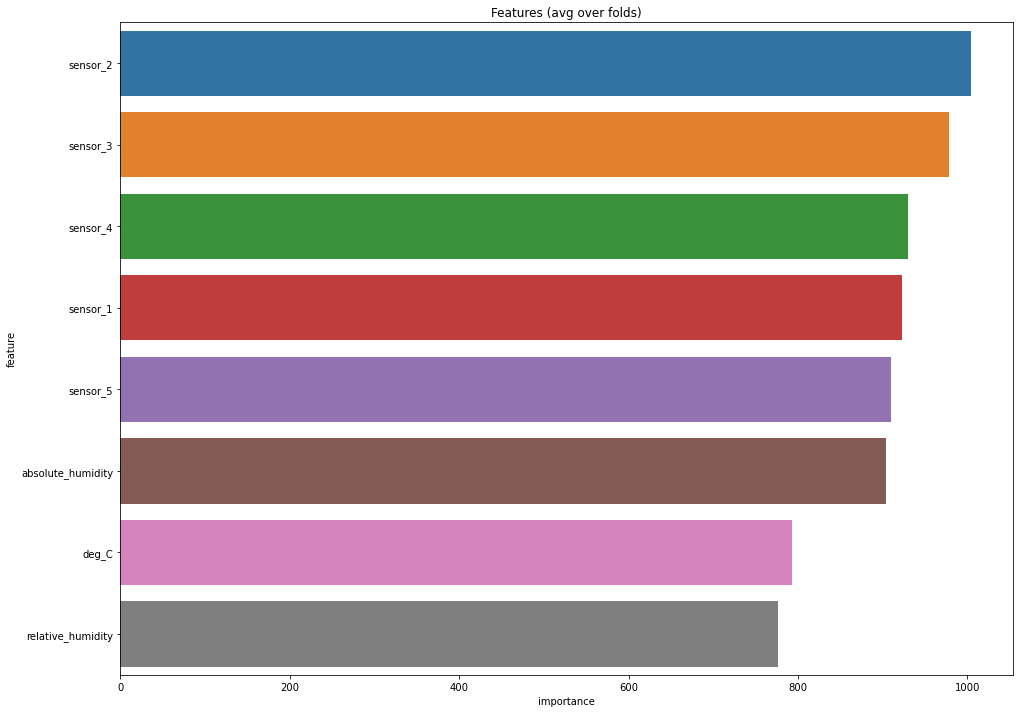

In [13]:

ts_split = TimeSeriesSplit(n_splits=5, test_size=train_df.shape[0]//5, gap=0)

train_Y = train_Ys["target_carbon_monoxide"]
results_dict_co = model.lgb_train_validate_on_cv(logger, 
                                               run_id=RUN_ID, 
                                               train_X=train_X,
                                               train_Y=train_Y,
                                               test_X=test_X,
                                               num_class=1,
                                               kf = ts_split,
                                               features = predictors,
                                               params = lgb_params,
                                               n_estimators=1000,
                                               early_stopping_rounds=100,
                                               cat_features= "auto",
                                               is_test=False,
                                               verbose_eval=100,
                                               label_name="co"
                                              )
train_index = train_df.index
common.save_artifacts(
    logger,
    is_test=False,
    is_plot_fi=True,
    result_dict=results_dict_co,
    submission_df=sample_submission_df,
    train_index=train_index,
    model_number=MODEL_NAME,
    run_id=RUN_ID,
    sub_dir=constants.SUBMISSION_DIR,
    oof_dir=constants.OOF_DIR,
    fi_dir=constants.FI_DIR,
    fi_fig_dir=constants.FI_FIG_DIR,
    label_name="co"
)


train_Y = train_Ys["target_benzene"]
results_dict_ben = model.lgb_train_validate_on_cv(logger, 
                                               run_id=RUN_ID, 
                                               train_X=train_X,
                                               train_Y=train_Y,
                                               test_X=test_X,
                                               num_class=1,
                                               kf = ts_split,
                                               features = predictors,
                                               params = lgb_params,
                                               n_estimators=1000,
                                               early_stopping_rounds=100,
                                               cat_features= "auto",
                                               is_test=False,
                                               verbose_eval=100,
                                               label_name="ben"
                                              )

train_index = train_df.index
common.save_artifacts(
    logger,
    is_test=False,
    is_plot_fi=True,
    result_dict=results_dict_ben,
    submission_df=sample_submission_df,
    train_index=train_index,
    model_number=MODEL_NAME,
    run_id=RUN_ID,
    sub_dir=constants.SUBMISSION_DIR,
    oof_dir=constants.OOF_DIR,
    fi_dir=constants.FI_DIR,
    fi_fig_dir=constants.FI_FIG_DIR,
    label_name="ben"
)


train_Y = train_Ys["target_nitrogen_oxides"]
results_dict_no = model.lgb_train_validate_on_cv(logger, 
                                               run_id=RUN_ID, 
                                               train_X=train_X,
                                               train_Y=train_Y,
                                               test_X=test_X,
                                               num_class=1,
                                               kf = ts_split,
                                               features = predictors,
                                               params = lgb_params,
                                               n_estimators=1000,
                                               early_stopping_rounds=100,
                                               cat_features= "auto",
                                               is_test=False,
                                               verbose_eval=100,
                                               label_name="no"
                                              )

train_index = train_df.index
common.save_artifacts(
    logger,
    is_test=False,
    is_plot_fi=True,
    result_dict=results_dict_no,
    submission_df=sample_submission_df,
    train_index=train_index,
    model_number=MODEL_NAME,
    run_id=RUN_ID,
    sub_dir=constants.SUBMISSION_DIR,
    oof_dir=constants.OOF_DIR,
    fi_dir=constants.FI_DIR,
    fi_fig_dir=constants.FI_FIG_DIR,
    label_name="no"
)



In [17]:
import numpy as np

In [21]:
(train_Ys == 0).sum()

target_carbon_monoxide    0
target_benzene            0
target_nitrogen_oxides    0
dtype: int64